# 0.0. IMPORTS

In [11]:
import os
import math
import time
import pickle
import datetime
import inflection 
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgbm
from boruta import BorutaPy
import matplotlib.ticker   as mticker
import matplotlib.colors   as mcolors
import matplotlib.pyplot   as plt


from scipy                   import stats
from operator                import attrgetter
from IPython.core.display    import HTML
from IPython.display         import Image
from imblearn                import combine as c
from sklearn.preprocessing   import LabelEncoder
from sklearn.ensemble        import RandomForestClassifier,RandomForestRegressor
from xgboost                 import XGBClassifier, DMatrix
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model    import LogisticRegression,LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score,StratifiedKFold

!pip install seaborn --upgrade
!pip install tabulate
!pip install boruta

# model's metrics
from sklearn.metrics        import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve

import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore');

Requirement already up-to-date: seaborn in c:\programdata\anaconda3\lib\site-packages (0.11.2)


## 0.1. Helper Functions

In [12]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    #plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def mean_absolute__percentage_error ( y, yhat ):
   return np.mean( np.abs( ( y -yhat ) /  y ) )   



def ml_error( model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y , yhat )
    rmse = np.sqrt( mean_squared_error( y ,yhat) )
    
    return pd.DataFrame( {'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse }, index=[0] )

def cramer_v( x, y):
    cm = pd.crosstab( a['state_holiday'], a['store_type'] ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def plot_with_target(target_x, target_y, col, position_x, position_y, label_x, label_y):
    """
    Create some histplots with target feature.

    Returns:
        [Image]: [Histplots of all features with target]
    """


    plt.style.use('tableau-colorblind10')
    ax[position_x, position_y].hist(target_x[col], bins = 50, alpha = 0.5, label= label_x) 
    ax[position_x, position_y].hist(target_y[col], bins = 50, alpha = 0.7, label= label_y) 
    ax[position_x, position_y].legend()
    ax[position_x, position_y].set_title(col)

    return ax

def point_bi_corr(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name));

def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)
    
    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

# Model's performance on test dataset function
def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat       = model.predict(x_test)
    yhat_proba = model.predict_proba(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df, yhat_proba

## 0.2. Loading Data

In [3]:
    display( HTML( '<style>.container { width:100% !important; }</style>') )

In [13]:
# reading files
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=True)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=True)

# merging files
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on= 'Store')

### 5.3.1. Encoding

### 5.3.1. Encoding

### 5.3.1. Encoding

### 5.3.1. Encoding

# 1.0. STEP 1 - DATA DESCRIPTION

In [14]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [15]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [16]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [17]:
df1['date'] = pd.to_datetime(df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [18]:
df1['competition_distance'].max()

75860.0

In [19]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [20]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] =  df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=True)
                                
# competition_open_since_year        
df1['competition_open_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=True)
                                                                                          
# promo2_since_week
df1['promo2_since_week'] =  df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=True)

# promo2_since_year  
df1['promo2_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=True)

In [21]:
# promo_interval 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',9: 'Sep' ,10: 'Oct', 11: 'Nov',  12: 'Dec'}


df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

In [22]:
df1.sample(5).T

,994404,229222,740180,143962,53151
store,610,648,606,128,747
day_of_week,1,3,5,2,7
date,2013-01-21 00:00:00,2015-01-07 00:00:00,2013-09-06 00:00:00,2015-03-24 00:00:00,2015-06-14 00:00:00
sales,6205,6559,4617,6351,0
customers,651,610,556,545,0
open,1,1,1,1,0
promo,1,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,d,c


## 1.6. Change Types

In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [24]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int', errors='ignore' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int', errors='ignore' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int', errors='ignore' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int', errors='ignore' )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [25]:
num_att = df1.select_dtypes( include= ['int64', 'float64'] )
cat_att = df1.select_dtypes( exclude= ['int64', 'float64', 'datetime64[ns]'] )

## 1.7.1. Numerical Attributes

In [26]:
cat_att.sample()

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map
283509,0,a,c,8,2013,5,2011,"Feb,May,Aug,Nov",Nov


In [27]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_att.apply( np.mean)  ).T
ct2 = pd.DataFrame( num_att.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_att.apply ( np.std )).T
d2 = pd.DataFrame( num_att.apply ( min )).T
d3 = pd.DataFrame( num_att.apply ( max )).T
d4 = pd.DataFrame( num_att.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_att.apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_att.apply ( lambda x: x.kurtosis() ) ).T
 
    
# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.165966,0.0,0.372050,1.795644,1.224338


<AxesSubplot:xlabel='sales', ylabel='Density'>

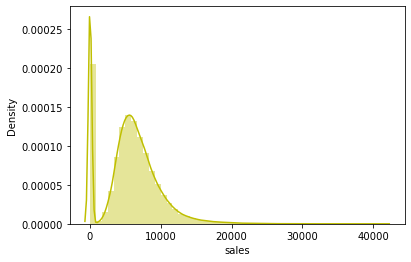

In [28]:
sns.distplot(df1['sales'],color='y')

## 1.7.2. Categorical Attributes

In [29]:
cat_att.apply( lambda x: x.unique().shape[0] )

state_holiday                    5
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

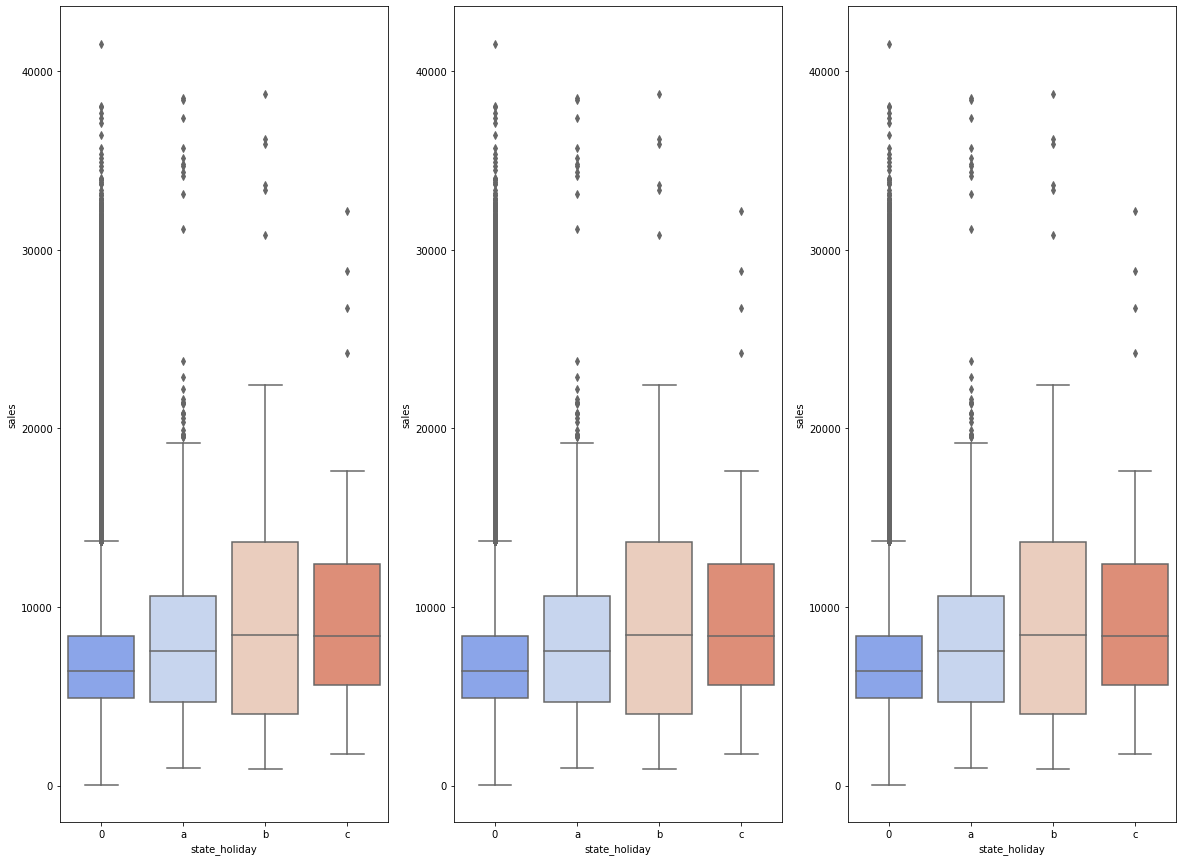

In [30]:
fig, aux1 = plt.subplots(figsize=(20,15))
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1, palette='coolwarm')

plt.subplot(1, 3, 2)
sns.boxplot( x='state_holiday', y='sales', data=aux1, palette='coolwarm' )

plt.subplot(1, 3, 3)
sns.boxplot( x='state_holiday', y='sales', data=aux1, palette='coolwarm' )

In [31]:
df2 = df1.copy()

In [32]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# transform 'float' to 'int' because of error
# df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)
# df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],  month=x['competition_open_since_month'], day= 1), axis=1) 
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) /30 ).apply( lambda x: x.days ).astype( int )
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply ( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days ).astype ( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a'else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 2.0. STEP 2 - FEATURE ENGINEERING

## 2.1. Hypothesis Mindmap

## 2.2. Creating Hypothesis

### 2.1.1 -  Store Hypothesis

**1.** Stores with more employers should sell more.

**2.** Stores with higher stock should sell more.

**3.** Bigger stores should sell more.

**4.** Stores with more options should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with competitors for longer should sell less. 


### 2.1.2 -  Products Hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores that expose more their products should sell more.

**3.** Stores that have lower prices should sell more.

**4.** Stores that have agressive discounts should sell more.

**5.** Stores that have promotions for longer should sell more.

**6.** Stores with higher number of active promo days sell more.

**7.** Stores with more consecutive promo days sell more.

### 2.1.3 -   Temporal Hypothesis

**1.** Stores that open on Christmas should sell more. 

**2.** Stores should sell more when around for longer.

**3.** Stores should sell more on the second semester.

**4.** Stores should sell more after the 10th.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays. 

## 2.3. Final Hypothesis

**1.**  Stores with more options should sell more.

**2.**  Stores with closer competitors should sell less.

**3.**  Stores with competitors for longer should sell more.

**4.**  Stores that have promotions for longer should sell more.

**5.**  Stores with higher number of active promo days sell more.

**6.**  Stores with more consecutive promo days sell more.

**7.**  Stores with more consecutive promo days sell more.

**8.**  Stores that open on Christmas should sell more.

**9.**  Stores should sell more when around for longer.

**10.** Stores should sell more on the second semester.

**11.** Stores should sell more after the 10th.

**12.** Stores should sell less on weekends.

**13.** Stores should sell less during school holidays.

In [33]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [34]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [35]:
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [36]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [37]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )


In [38]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EXPLORATORY ANALYSIS

In [39]:
df4 = df3.copy()

## 4.1. Univariable Anaysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

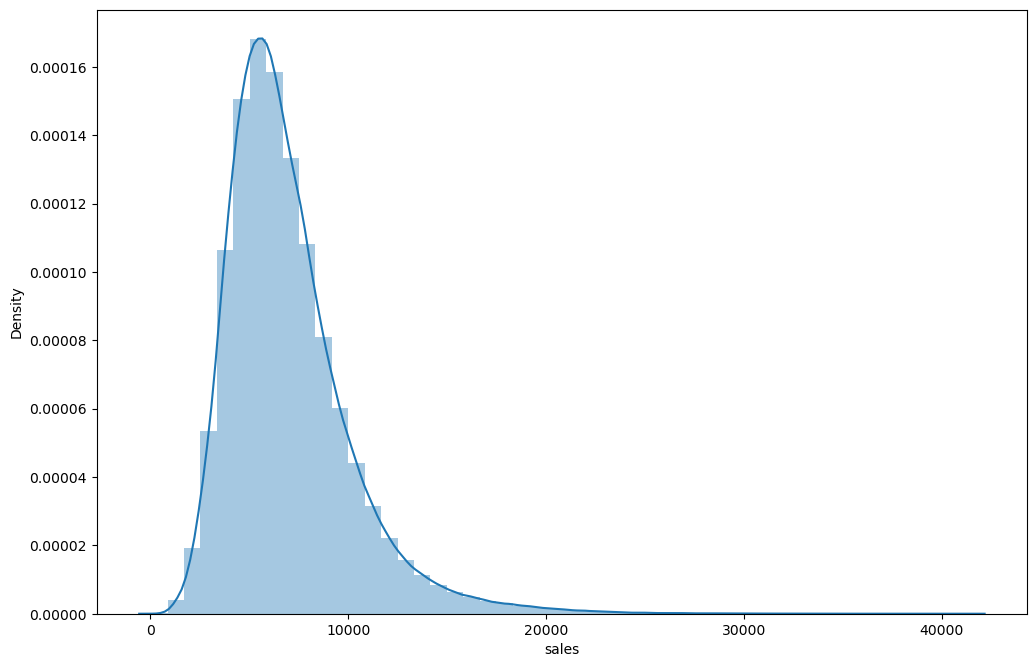

In [40]:
fig, ax = plt.subplots(figsize=(12,8),dpi=100);
sns.distplot(df4['sales'] )

### 4.1.2. Numerical Variable

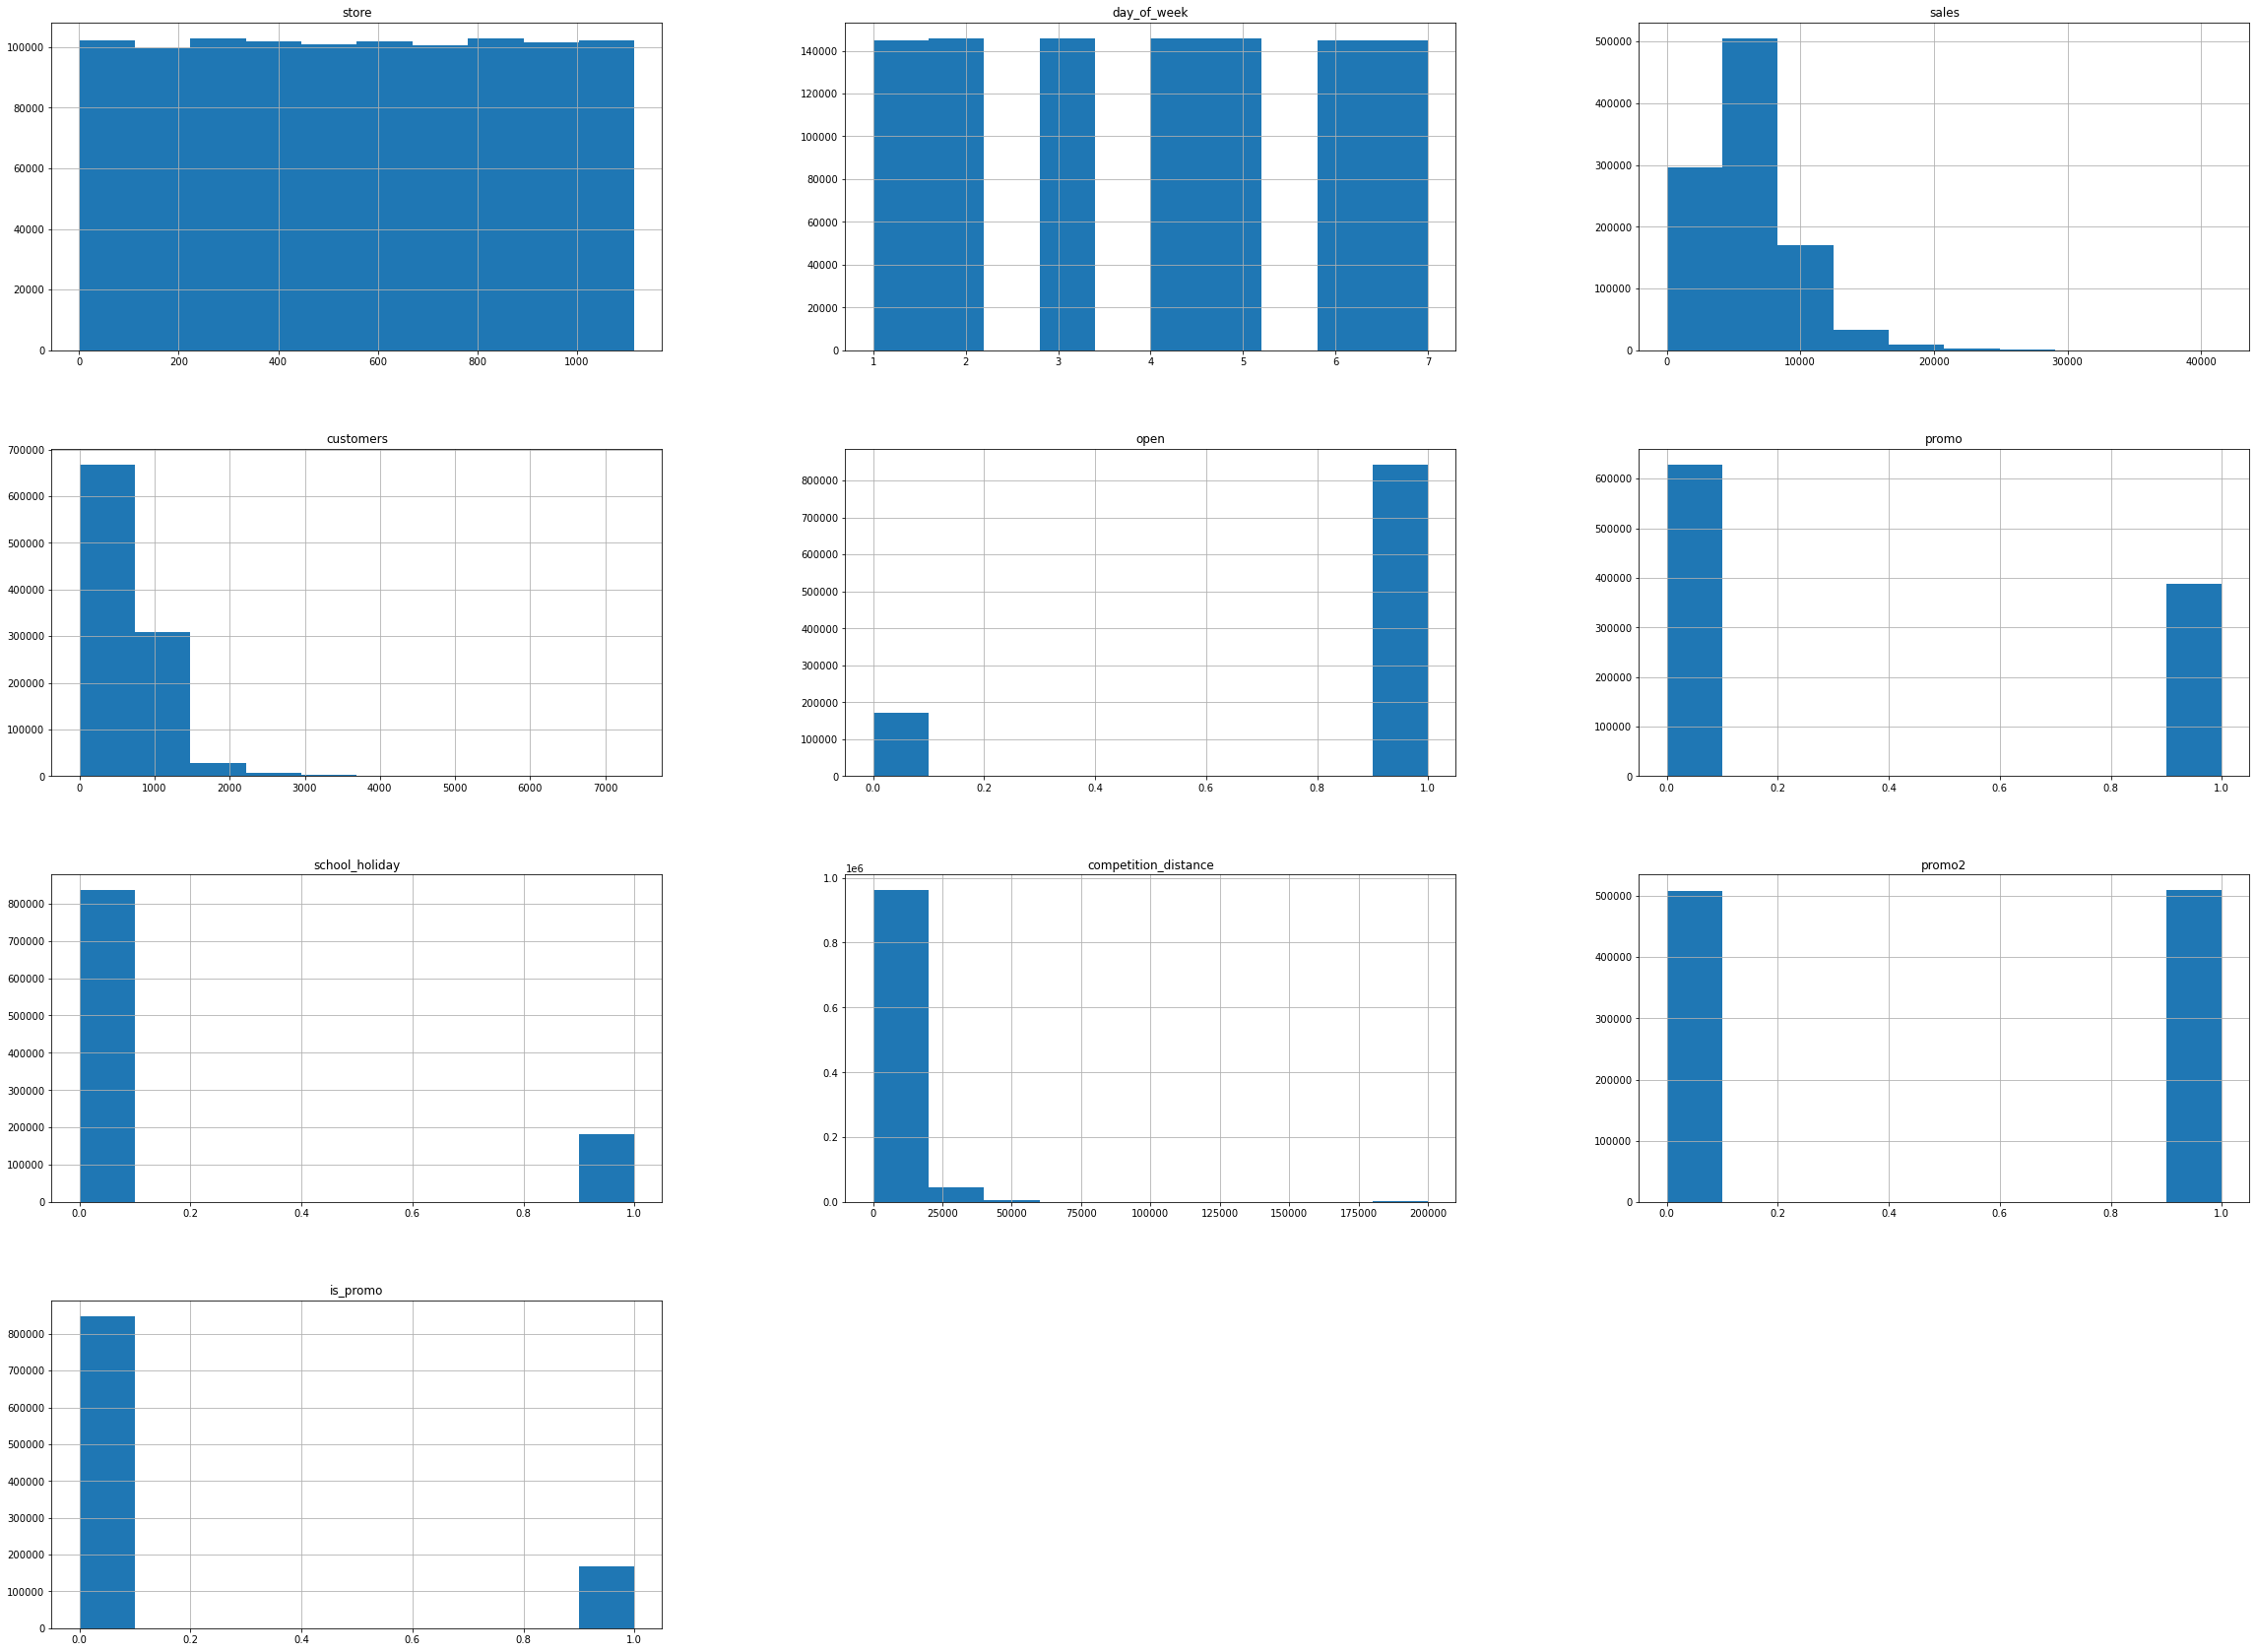

In [41]:
 fig = num_att.hist(figsize=(40,30))

In [42]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

### 4.1.3. Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

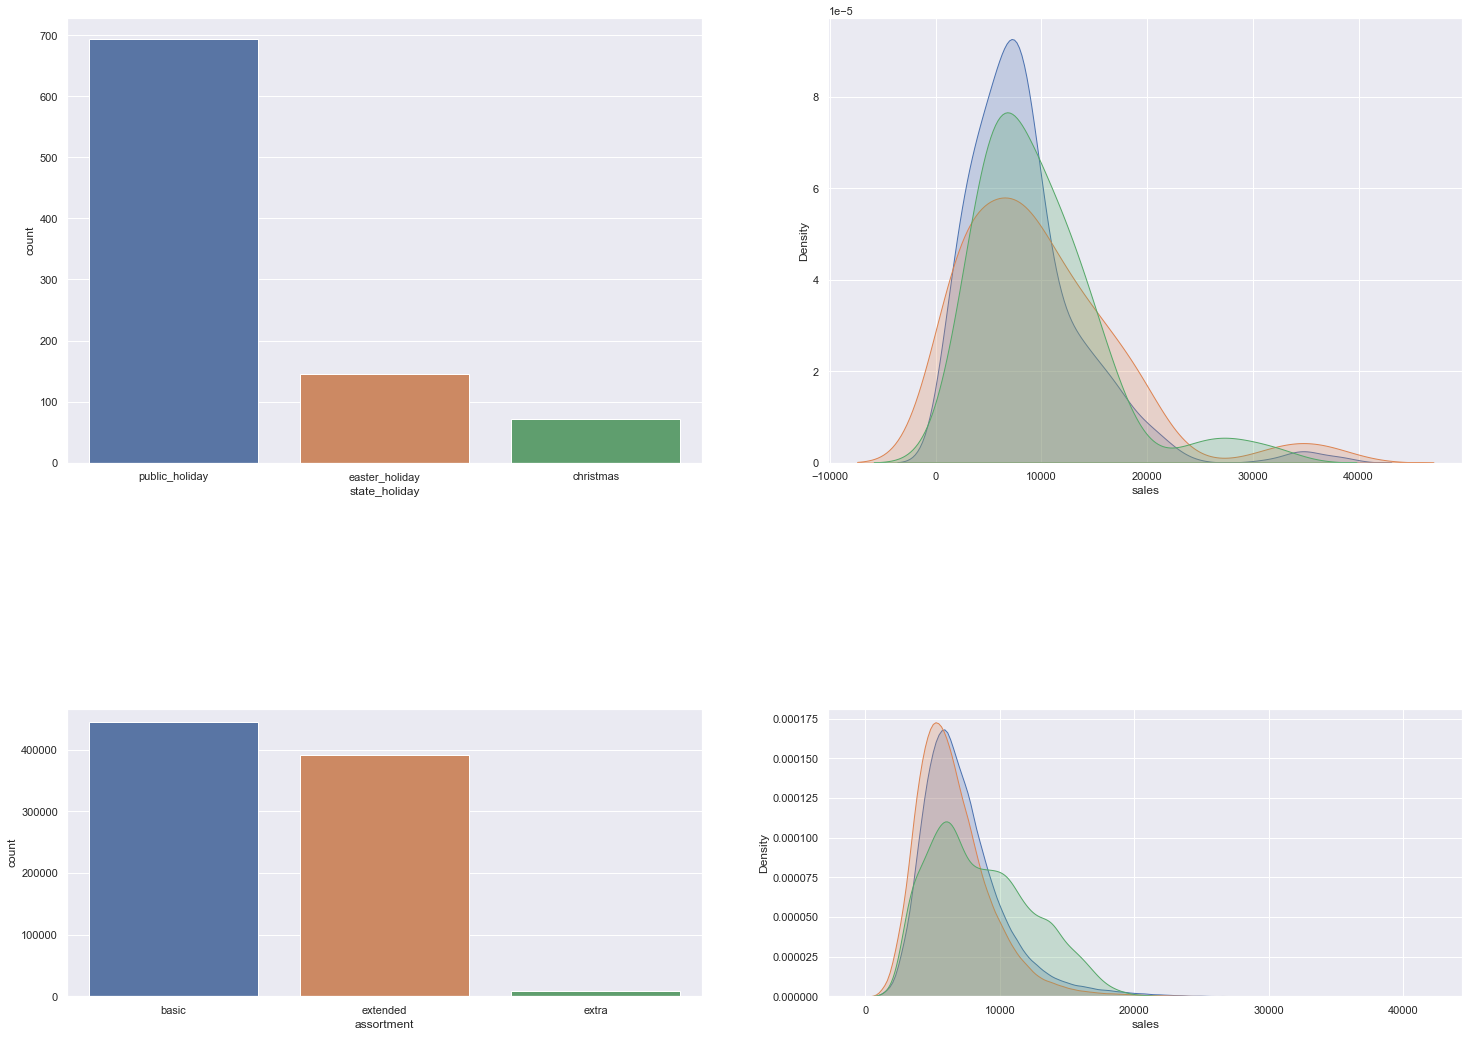

In [43]:
sns.set_theme()                                           
plt.rcParams['figure.figsize'] = [25, 18]                         
# state_holiday
plt.subplot(2, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(2, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True,)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True,)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas_holiday',shade=True,)

# store_type
plt.subplot(2, 2, 3 )

sns.countplot( df4['store_type'] )

plt.subplot(2, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a',shade=True,)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b',shade=True,)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c',shade=True,)

# assortment
plt.subplot(3, 2, 5 )

sns.countplot( df4['assortment'] )

plt.subplot(3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True,)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True,)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True,)

## 4.2. Bivariable Anaysis

### H1. Stores with more options should sell more.
**FALSE.** Stores with more options sell less.

<AxesSubplot:xlabel='year_week'>

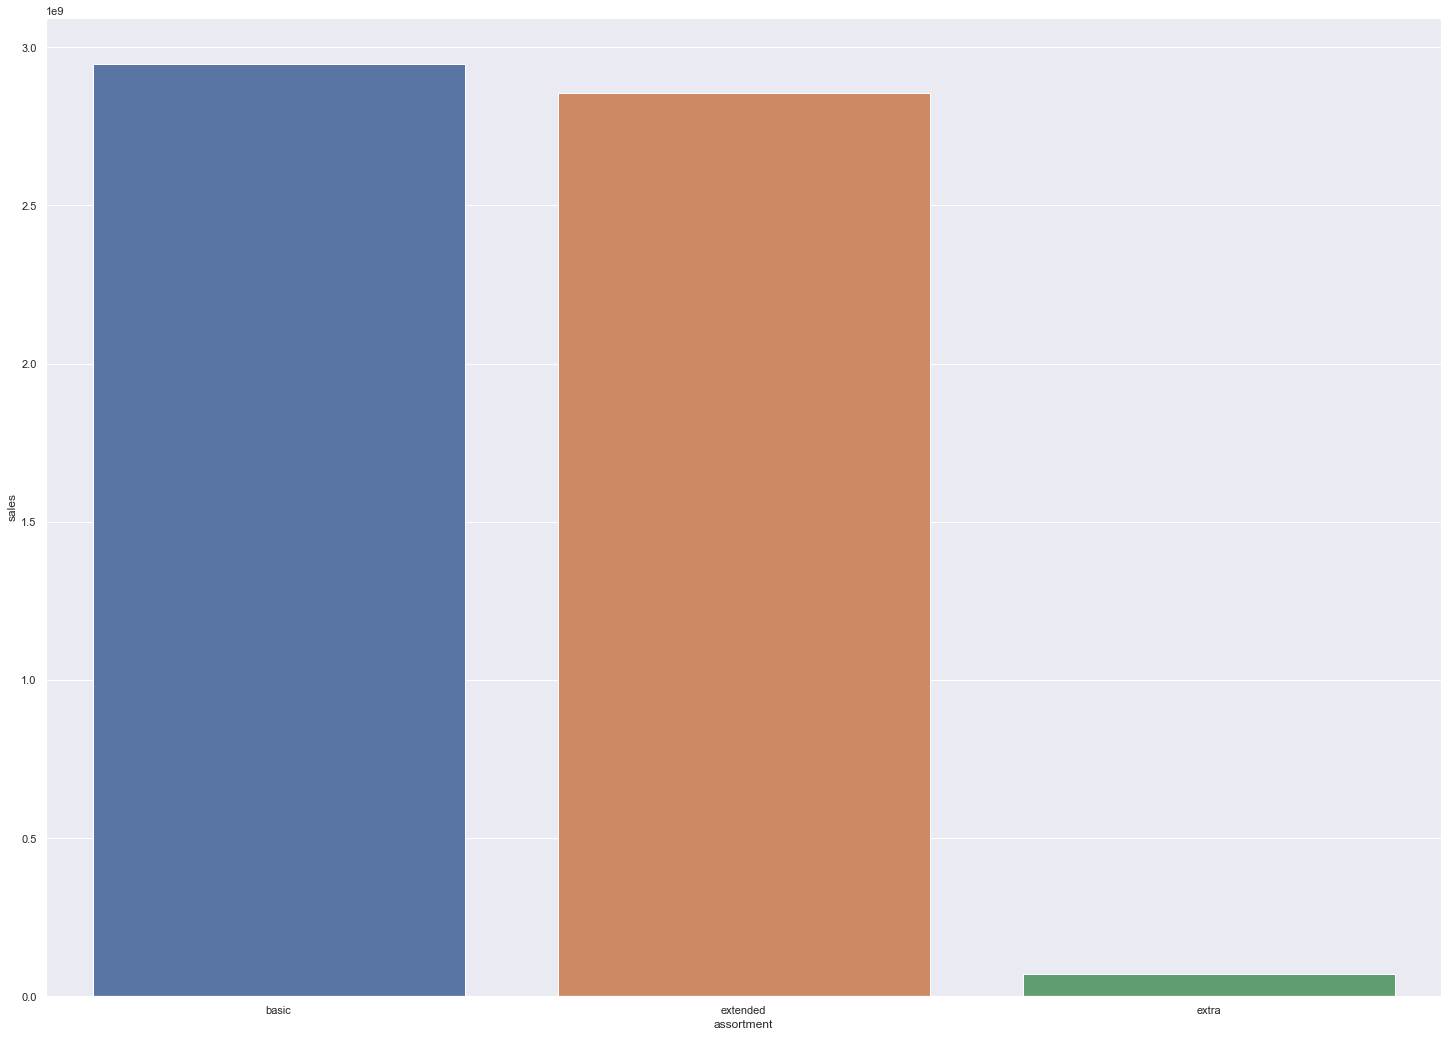

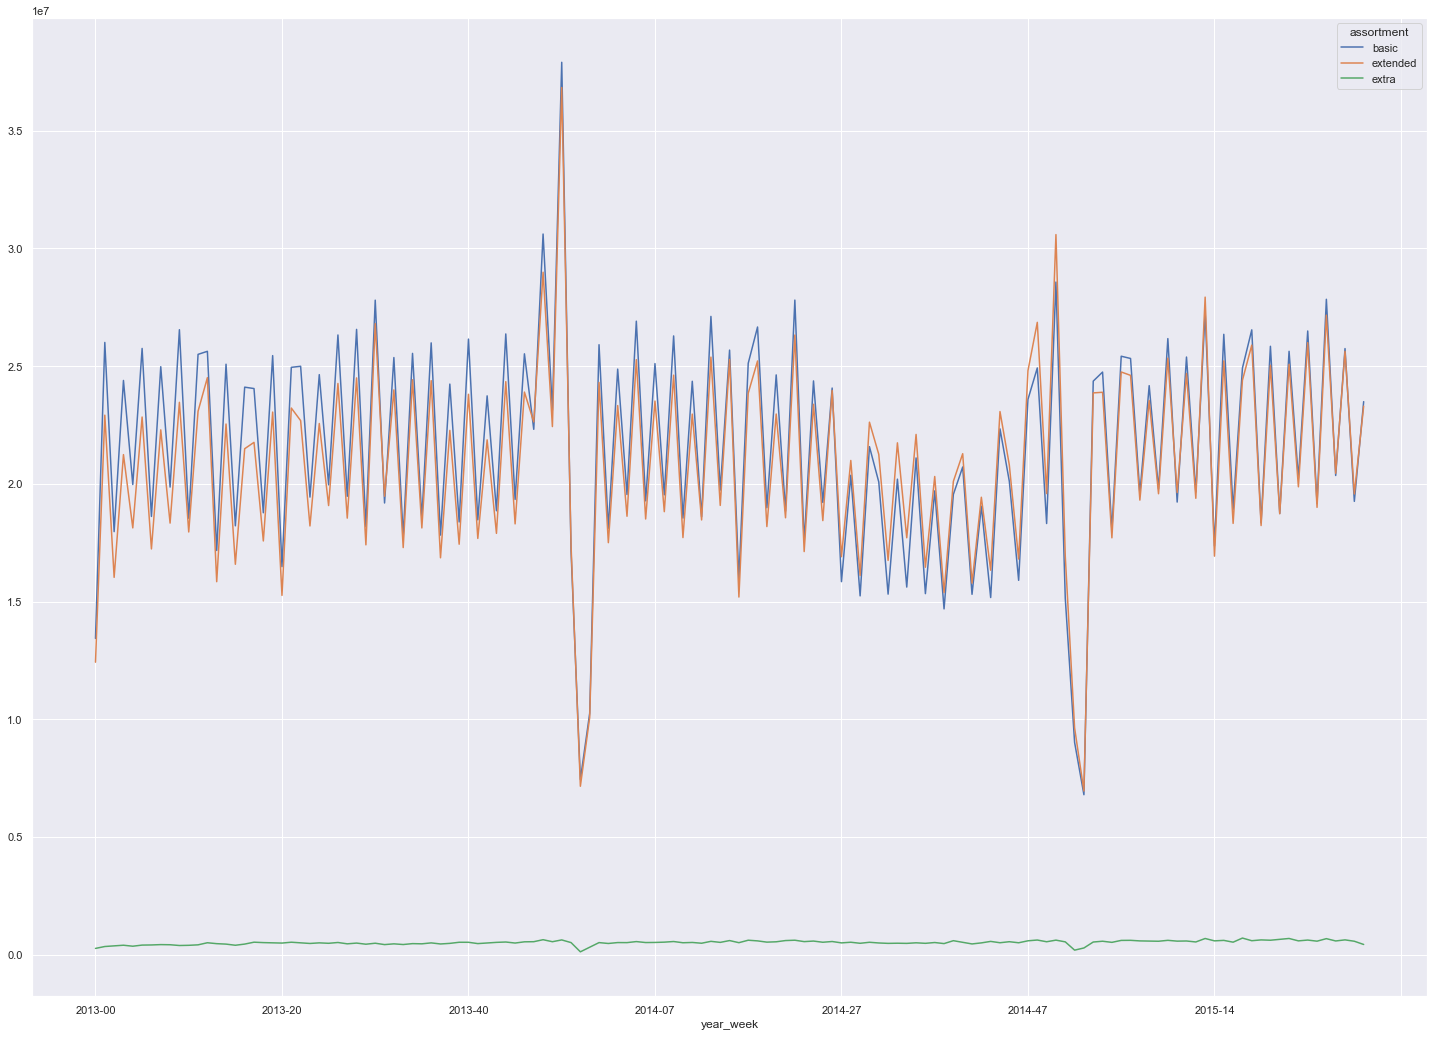

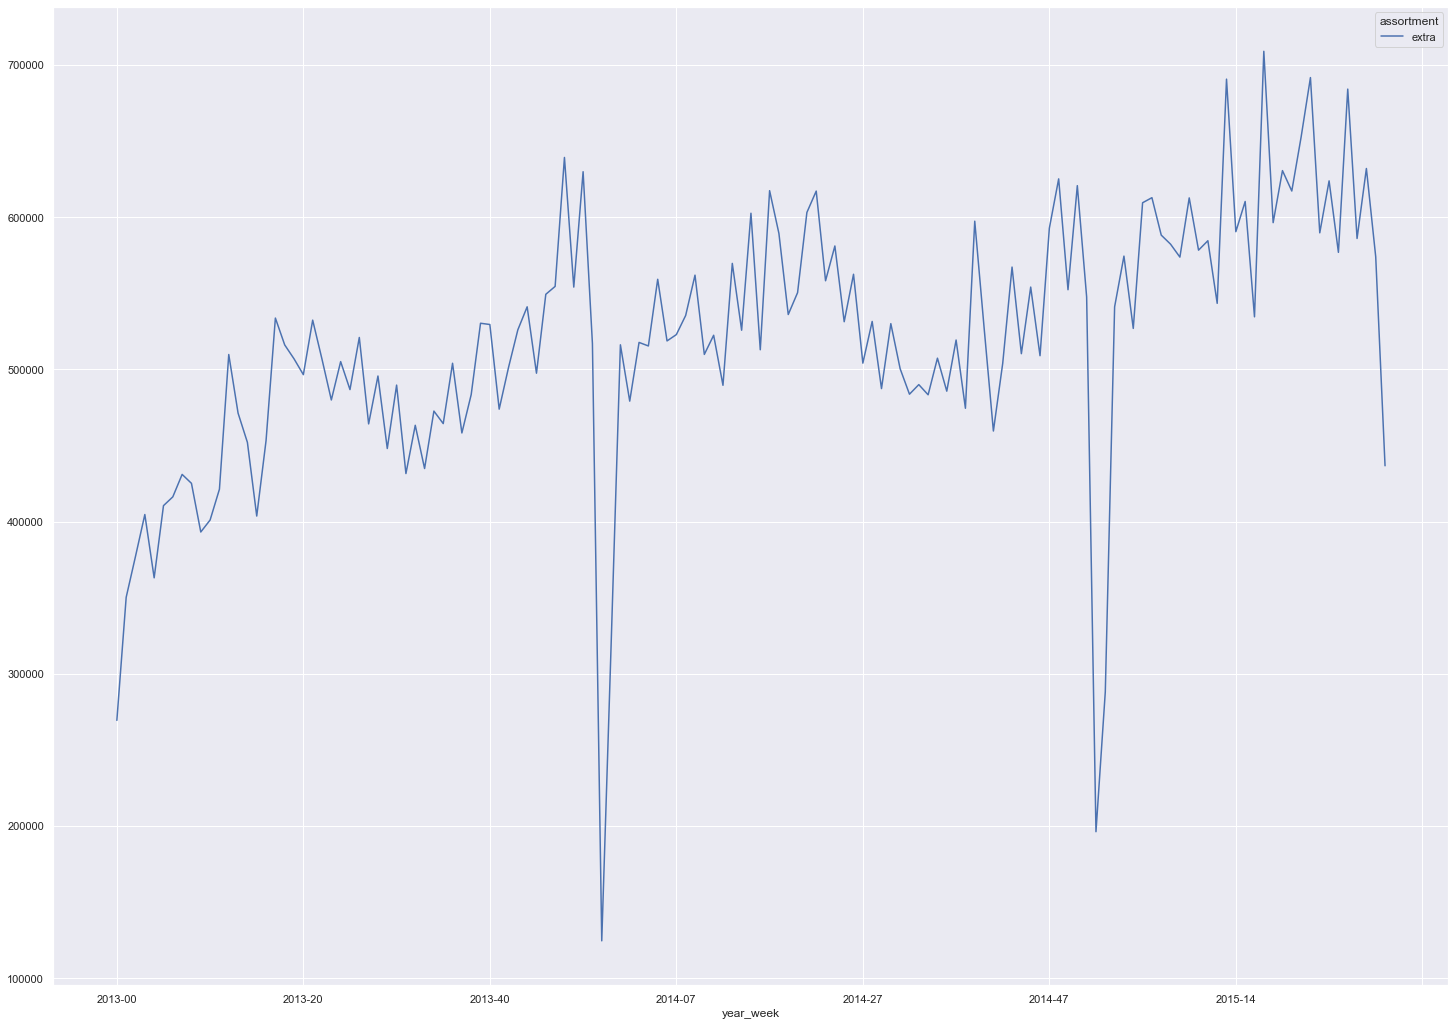

In [44]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x= 'assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()

### H2. Stores with closer competitors should sell less.
**FALSE**. Stores with closer competitors sell more.

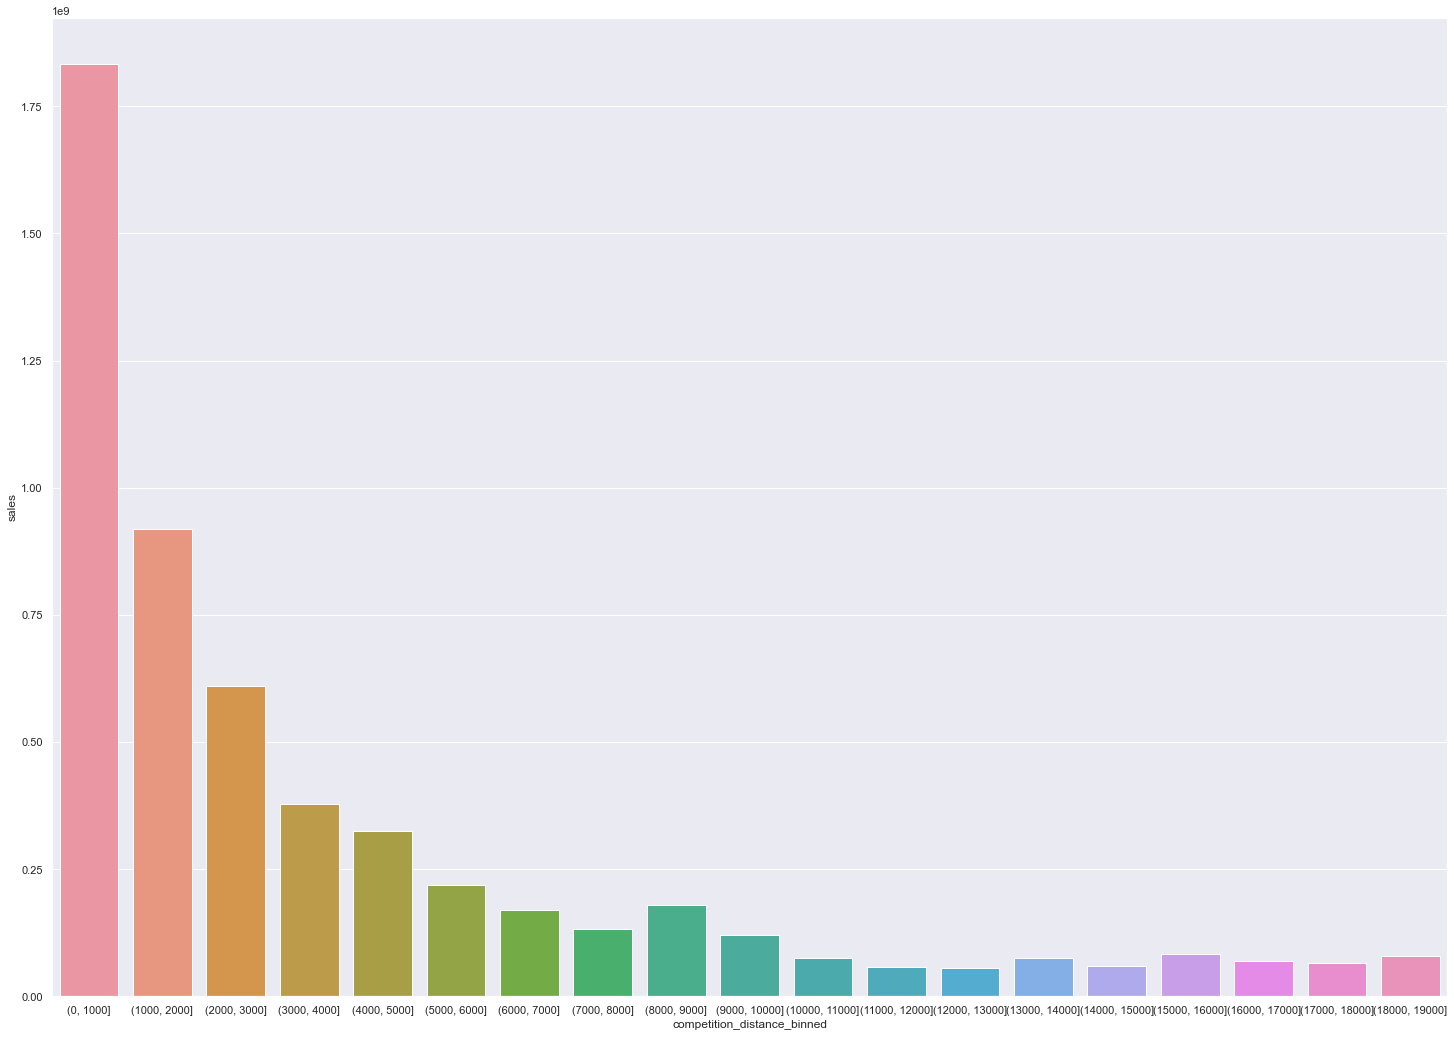

In [45]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list( np.arange( 0,  20000, 1000) )

aux1['competition_distance_binned']=  pd.cut(aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot( x= 'competition_distance_binned', y= 'sales', data=aux2);
 

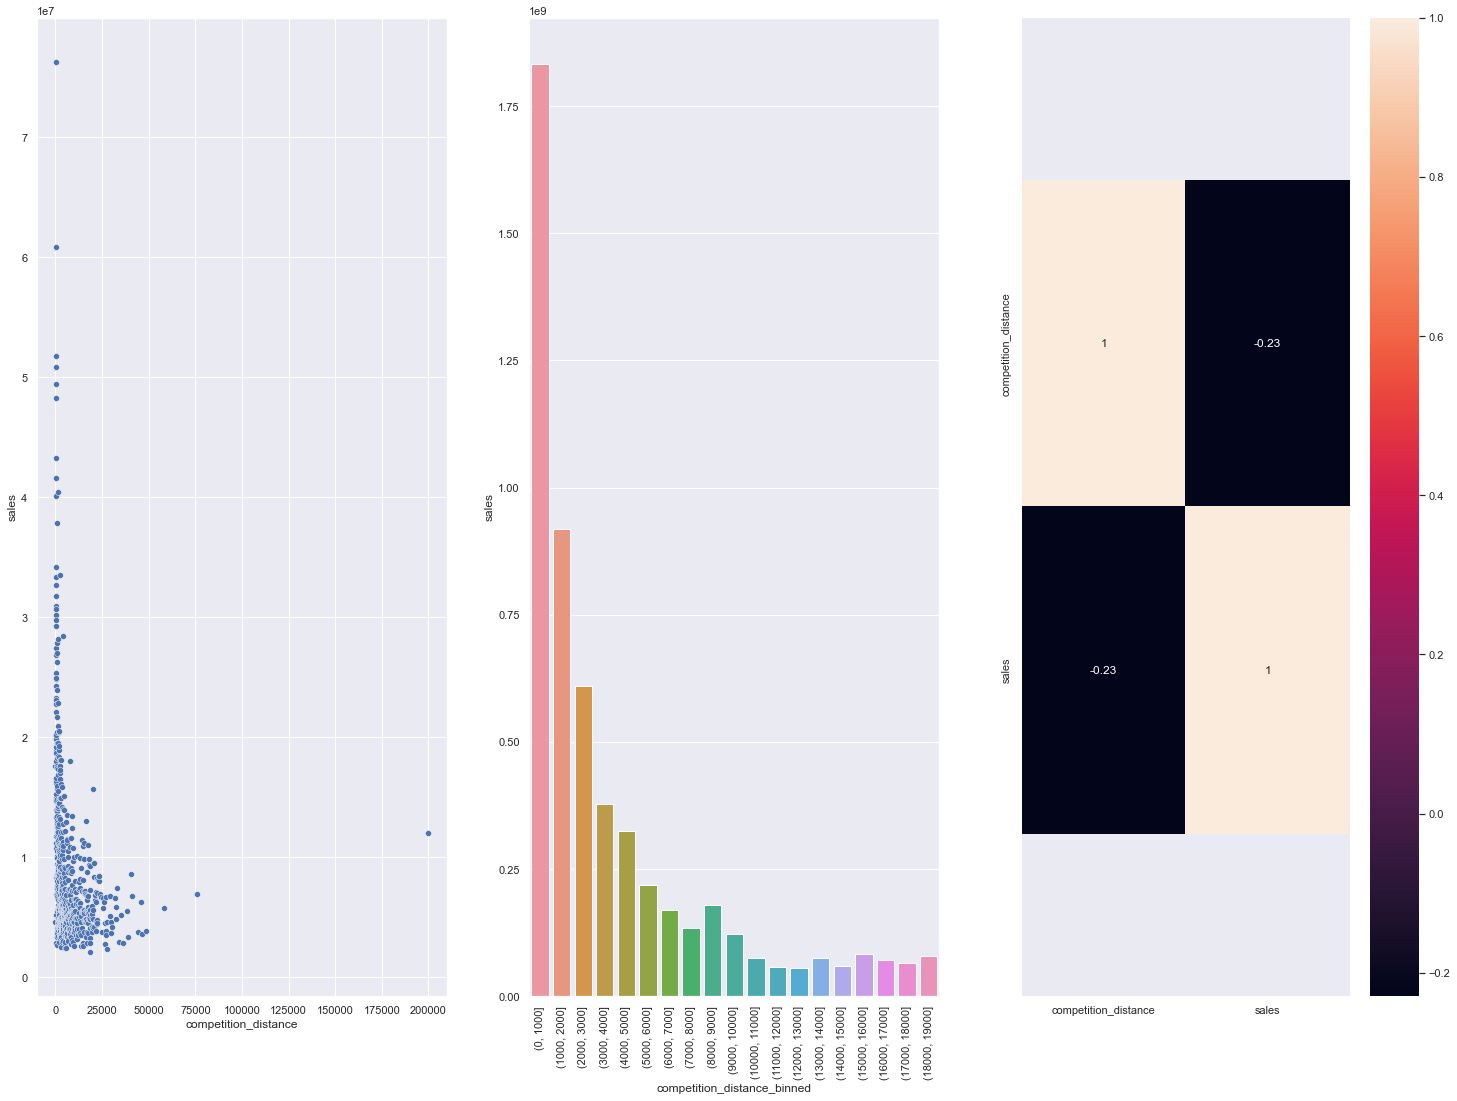

In [46]:
# measuring the corelation between the distance and the voume of sales
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1 )
sns.scatterplot(x='competition_distance',y='sales', data=aux1 );

plt.subplot(1, 3, 2 )
bins = list( np.arange( 0,  20000, 1000) )
aux1['competition_distance_binned']=  pd.cut(aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x= 'competition_distance_binned', y= 'sales', data=aux2);

# rotate axis for better visualization
plt.xticks( rotation= 90);


plt.subplot( 1, 3, 3)
x= sns.heatmap( aux1.corr( method='pearson' ), annot=True);
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### H3.  Stores that had competitors around for longer should sell more.
**FALSE**. Stores that had competitors around for longer sell less.

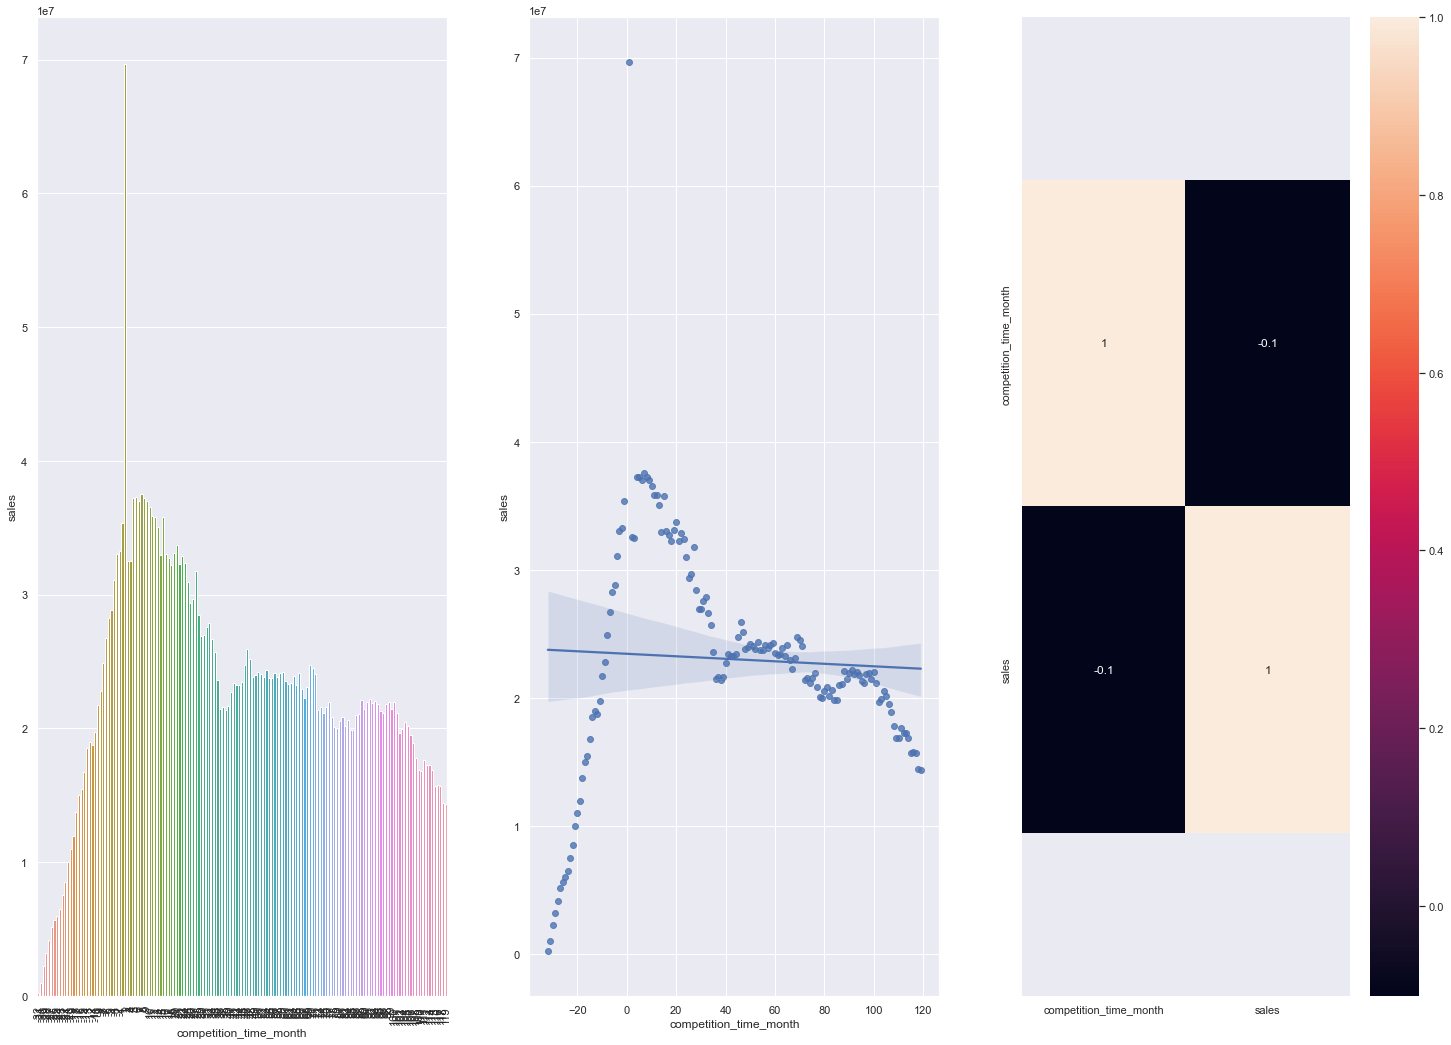

In [47]:
plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month']  != 0)]
sns.barplot(x= 'competition_time_month',y='sales',data=aux2);
plt.xticks( rotation=90);

plt.subplot( 1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot( 1, 3, 3)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### H4. Stores with higher number of active promo days sell more.

In [48]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

plt.subplot ( 2, 2, 1)
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promo
sns.barplot( x='promo_time_week', y='sales', data=aux2)
plt.xticks (rotation= 90)

plt.subplot( 2, 2, 2)
sns.regplot( x='promo_time_week', y='sales', data=aux2)

plt.subplot( 2, 2, 3)
aux3 = [aux1[aux1['promo_time_week'] < 0] # regular promo
sns.barplot( x='promo_time_week', y='sales', data=aux3)
plt.xticks( rotation=90)
        
plt.subplot( 2, 2, 4)        
sns.regplot( x='promo_time_week', y='sales', data=aux3)

SyntaxError: invalid syntax (<ipython-input-48-f9995811f770>, line 13)

### H5. Stores with more consecutive promo days sell more. 
**Standby**

### H6. Stores with more consecutive promo days sell more.

In [50]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


### H6. Stores with more consecutive promo days sell more.

### H7. Stores that open on Christmas should sell more.

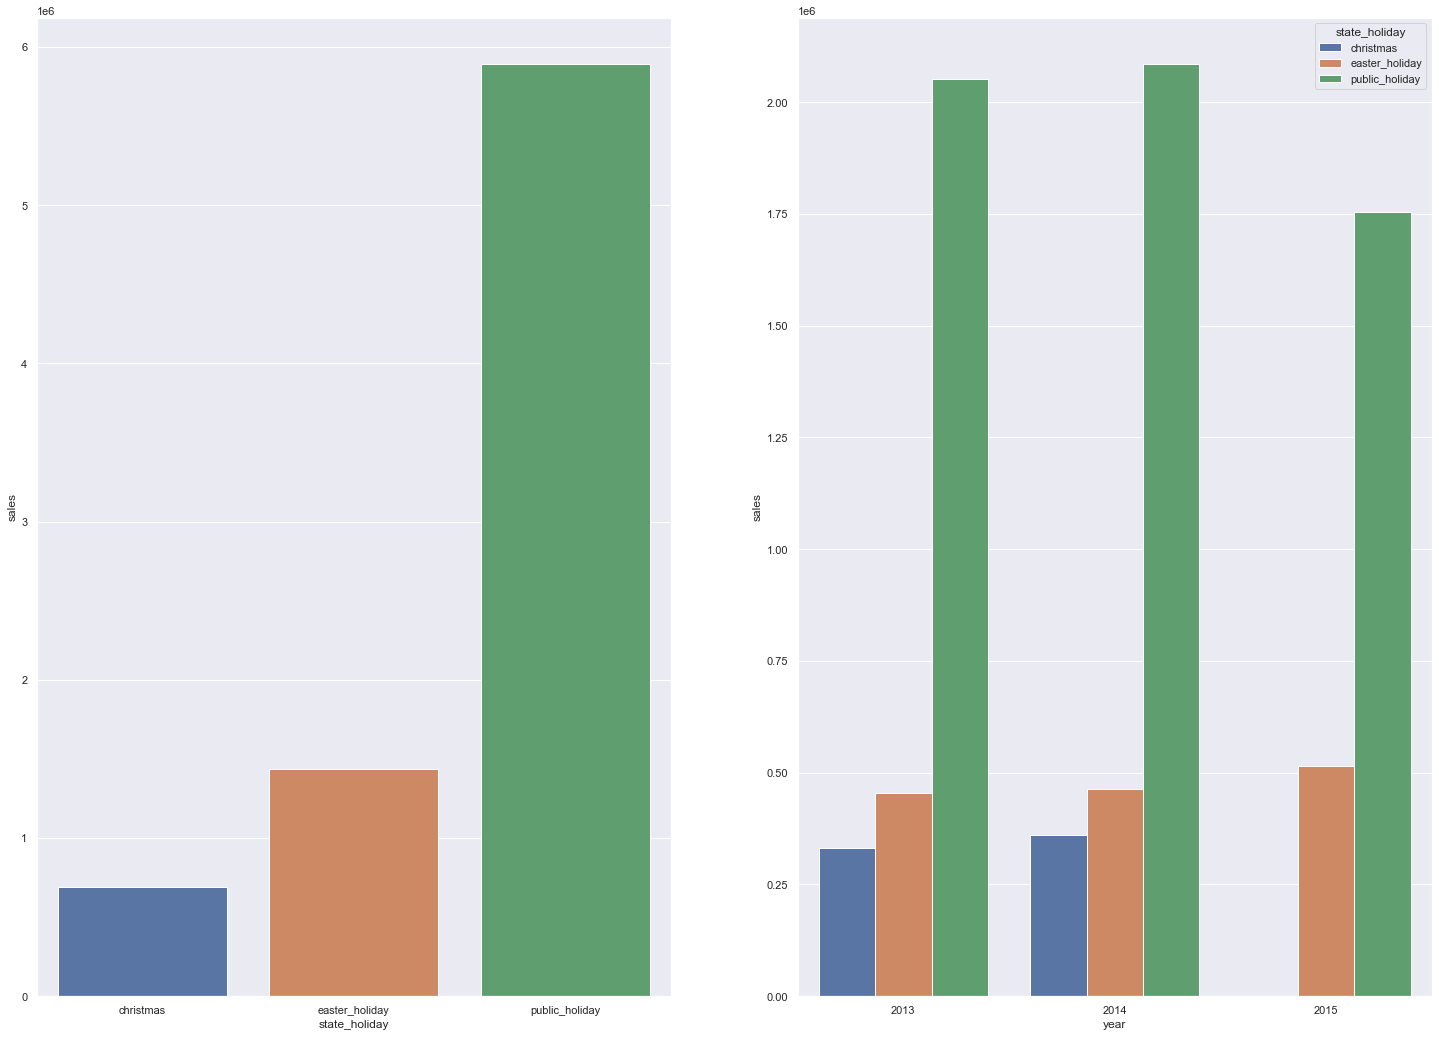

In [51]:
aux= df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales',hue='state_holiday', data=aux2);

### H8. Stores should sell more throughout the years.
**False** Stores sell less throughout the years.

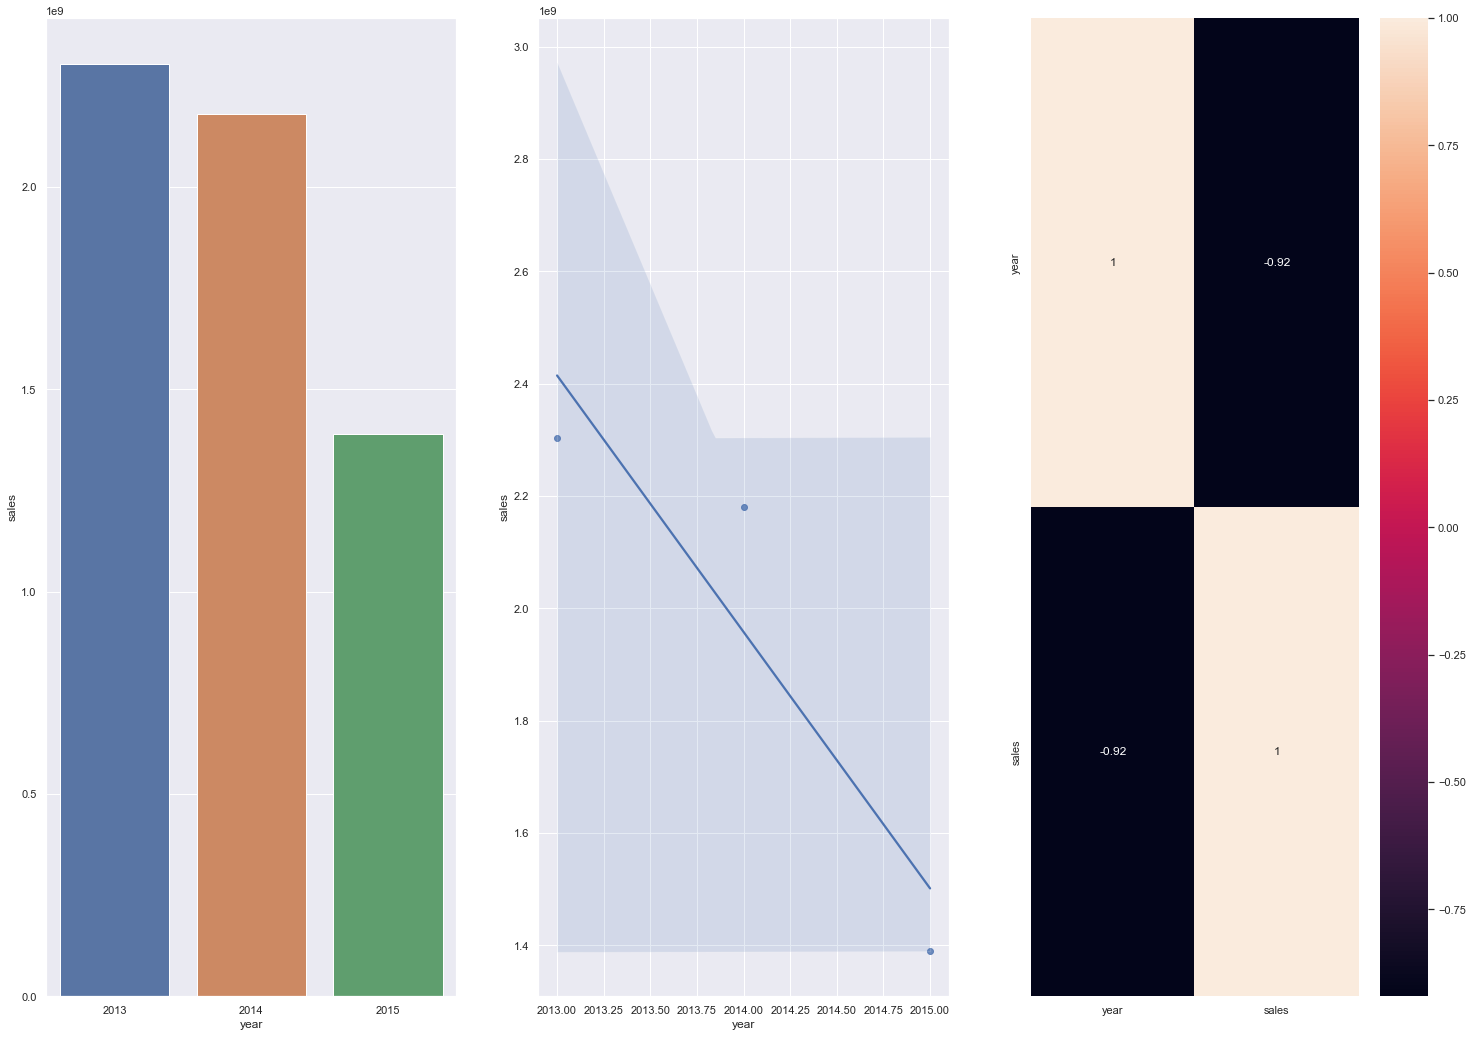

In [52]:
aux1 = df4[['year', 'sales']].groupby( 'year').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method= 'pearson'), annot=True );

### H9. Stores should sell more on the second semester.
**False** Stores sell less in the second semester. 

### H10. Stores should sell more on the second semester.

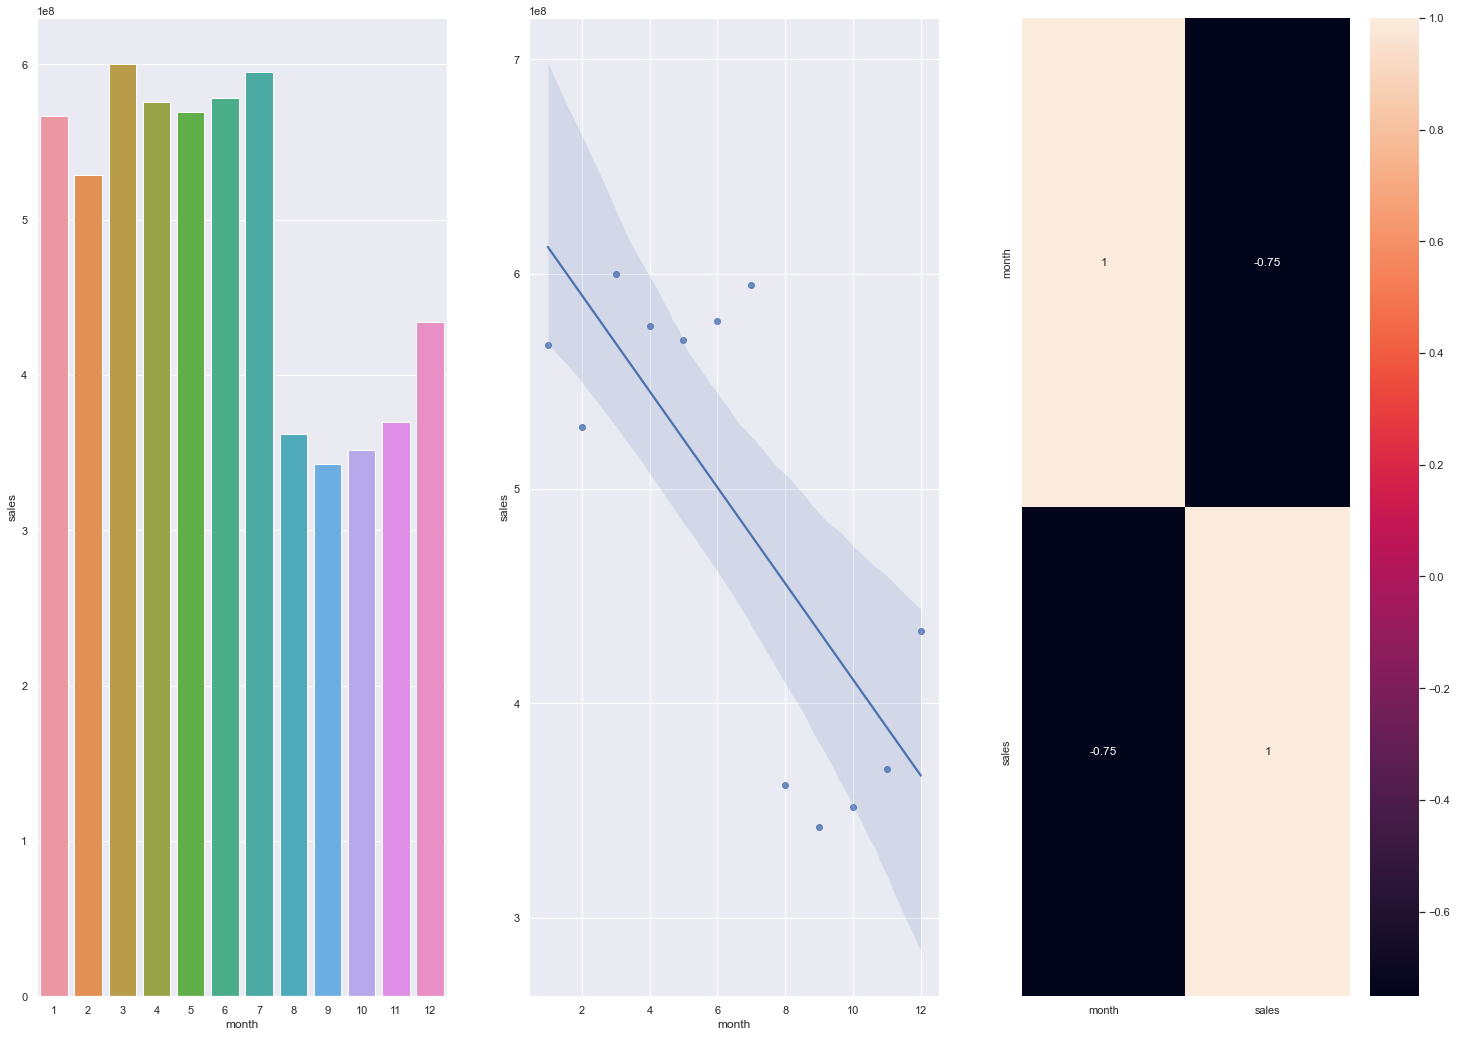

In [53]:
aux1 = df4[['month', 'sales']].groupby( 'month').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method= 'pearson'), annot=True );

### H11. Stores should sell more after the 10th.
**True**   

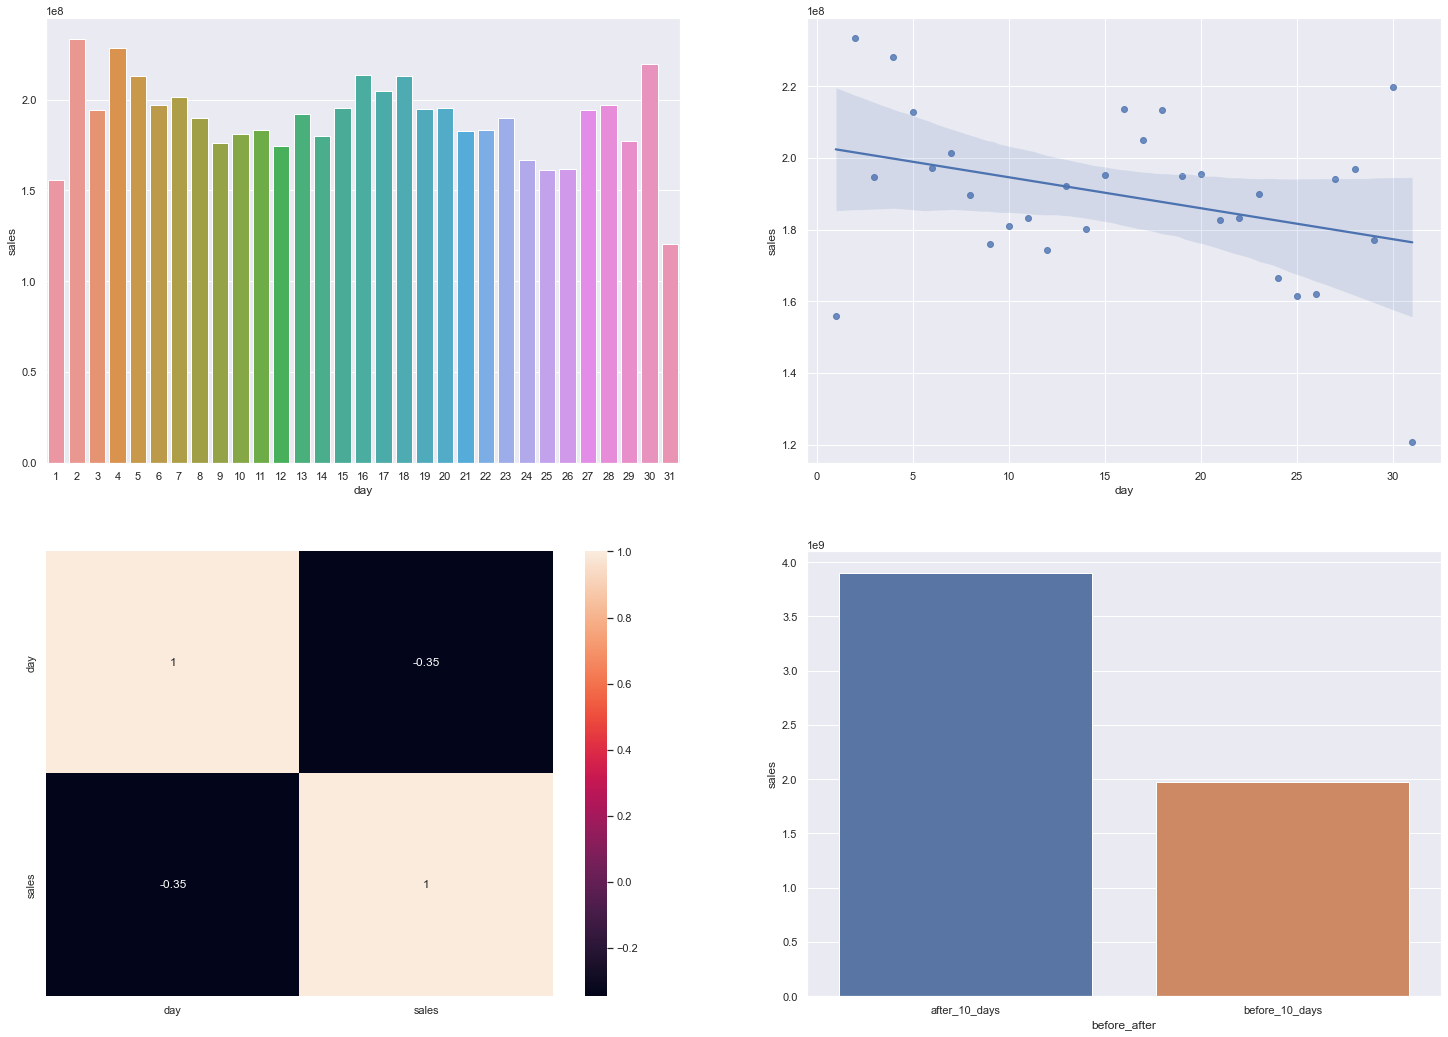

In [54]:
aux1 = df4[['day', 'sales']].groupby( 'day').sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method= 'pearson'), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2);

### H12. Stores should sell less on weekends.
**True**

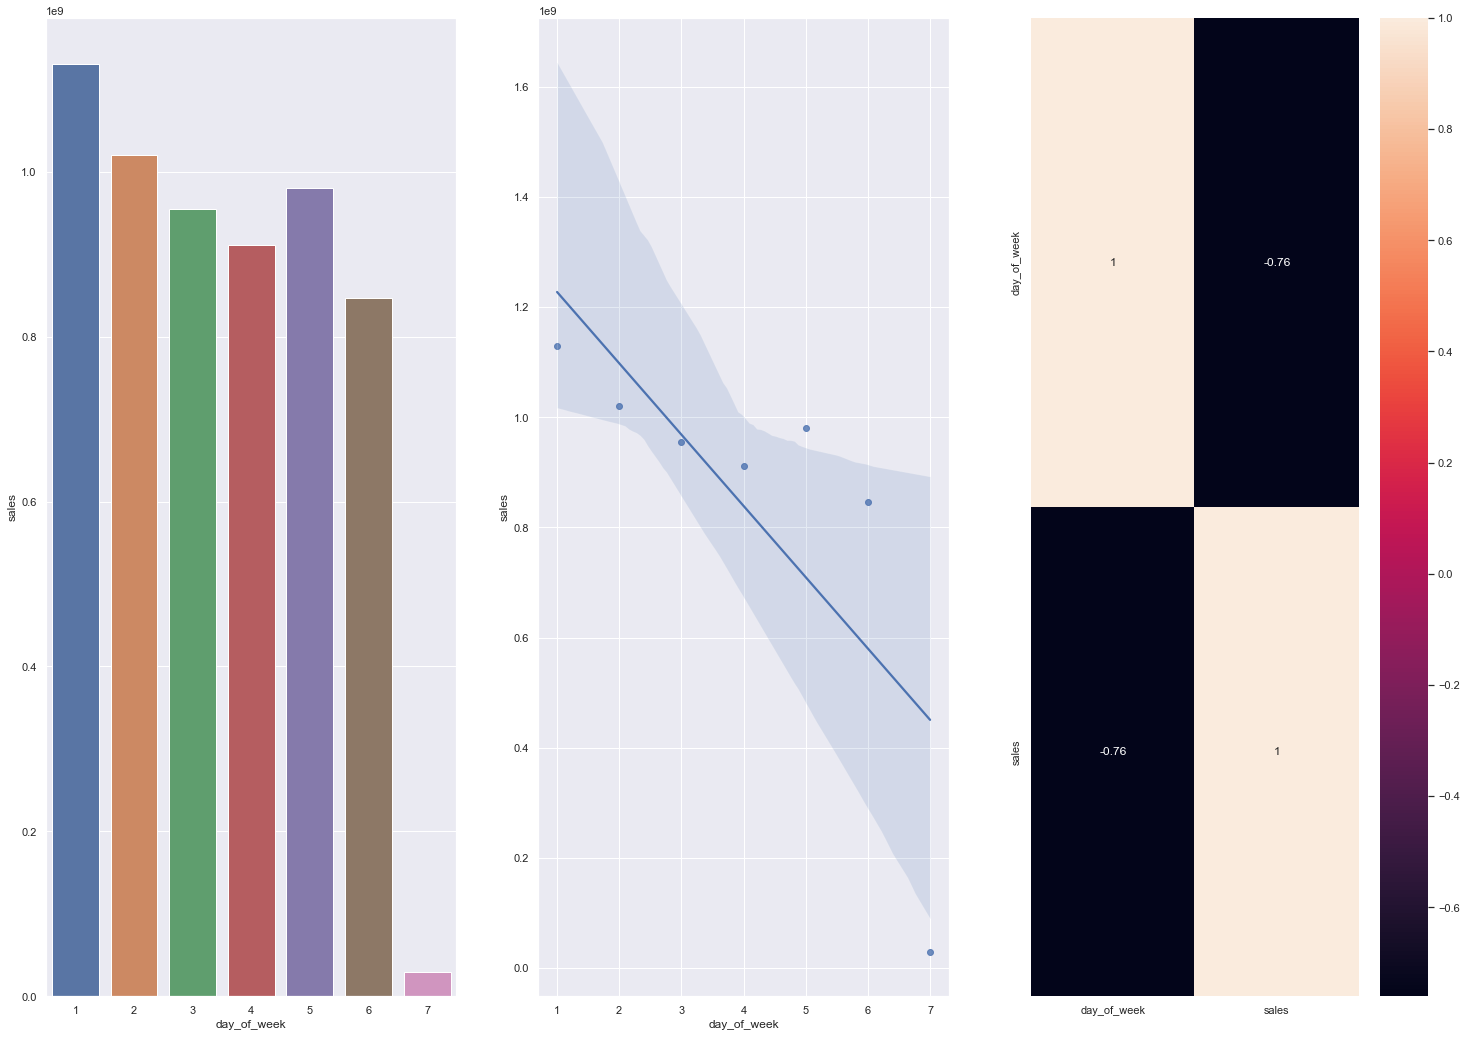

In [55]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method= 'pearson'), annot=True );

### H13.Stores should sell less during school holidays.

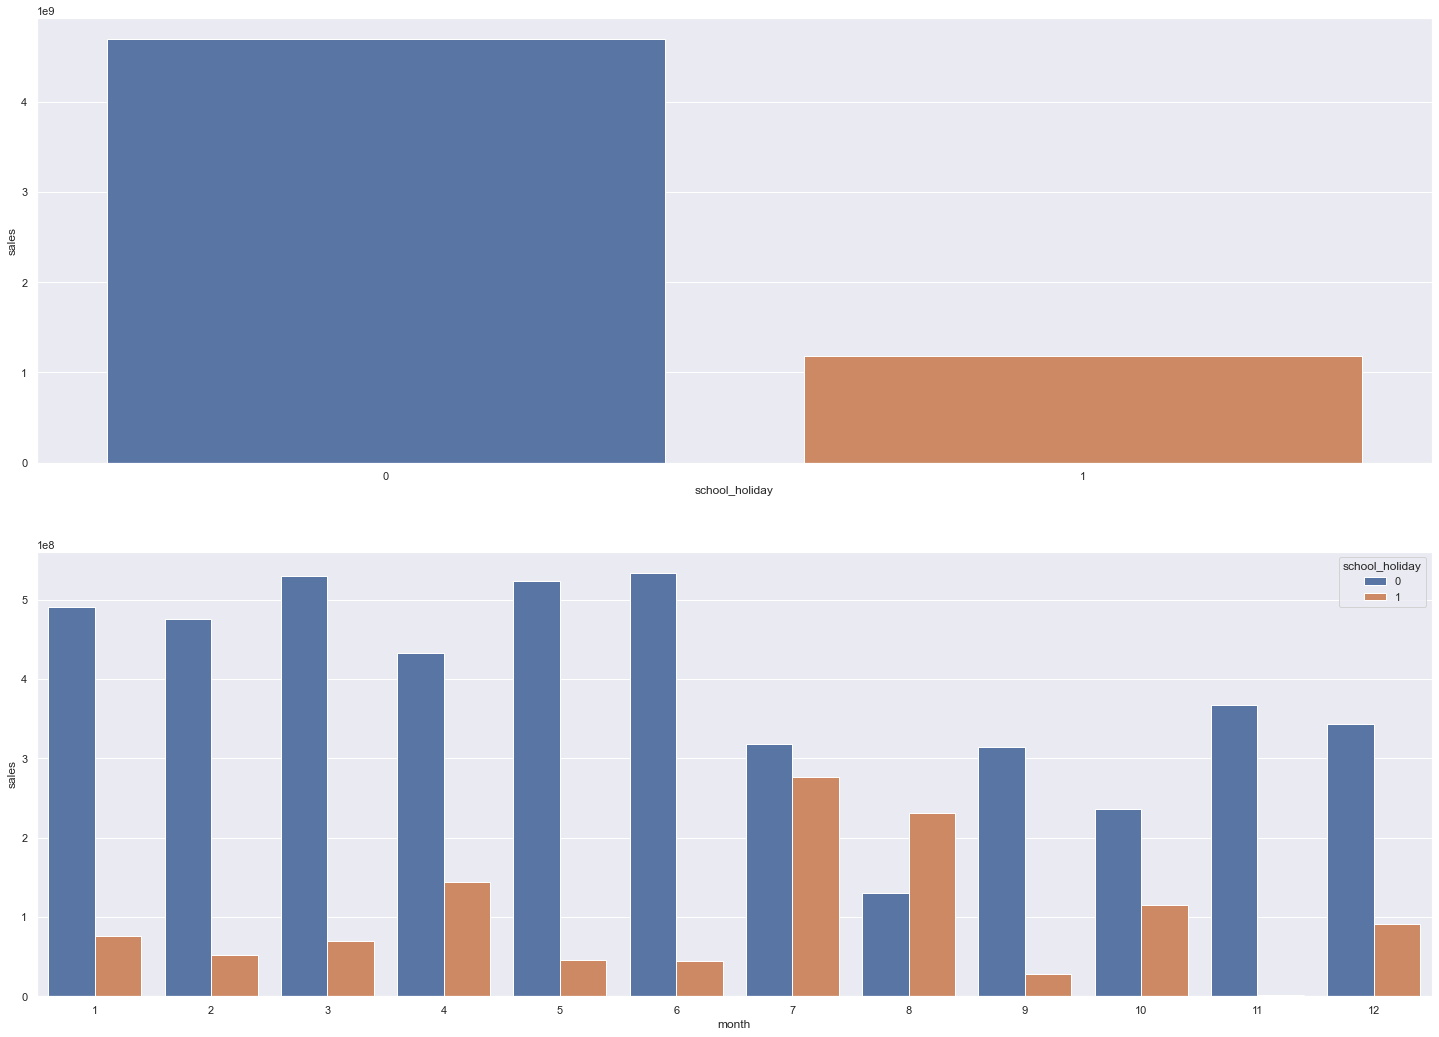

In [56]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday').sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month','school_holiday', 'sales']].groupby( ['month','school_holiday']).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday',data=aux2);

## 4.3. Multivariable Anaysis

### 4.3.1 Numerical Attributes

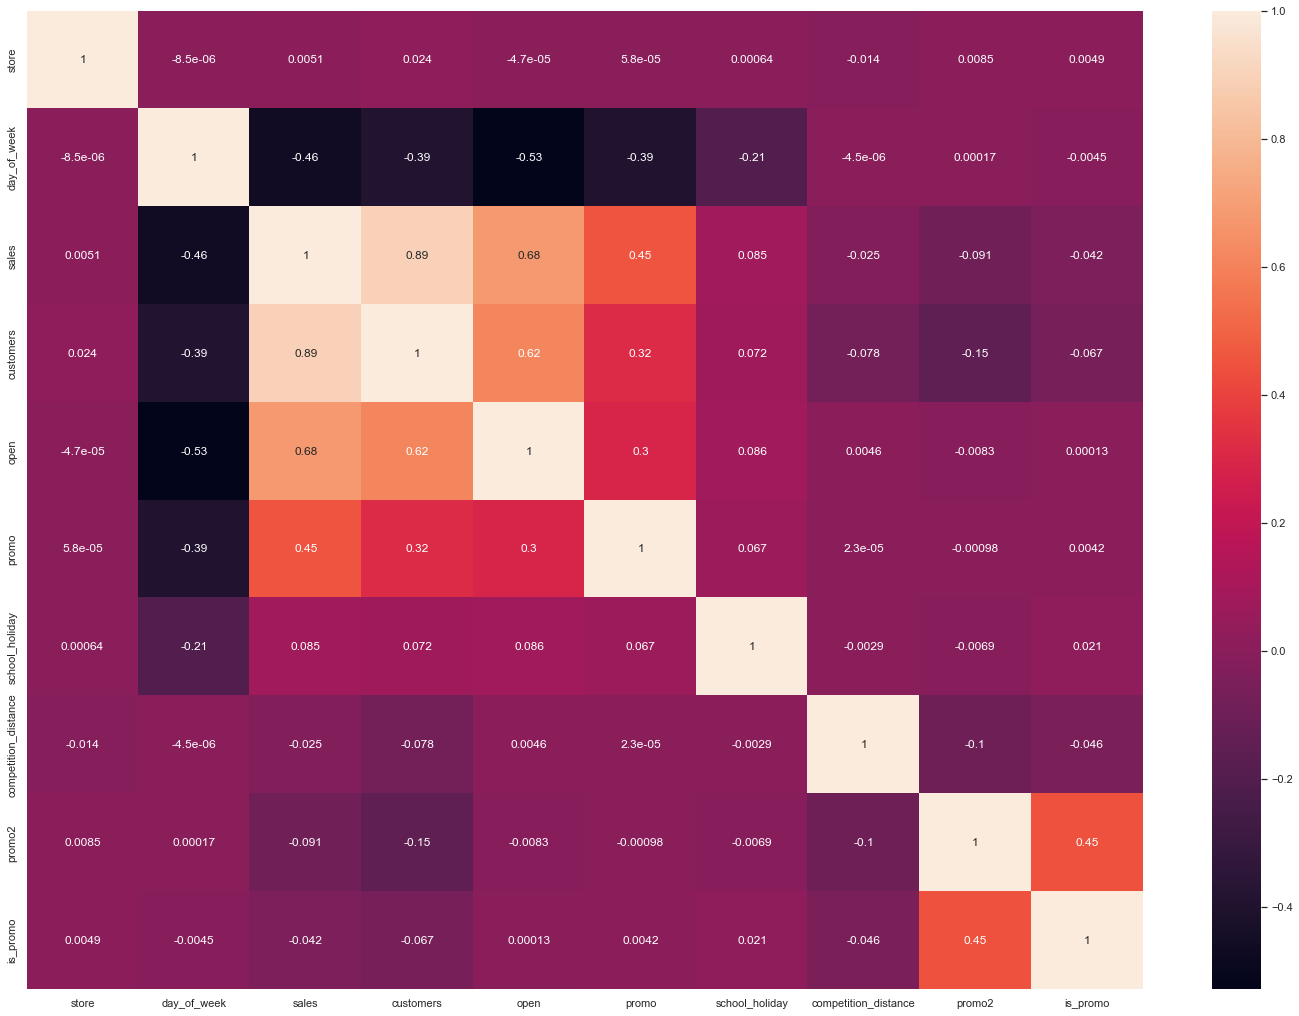

In [57]:
# Correlation between variables
correlation = num_att.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

In [60]:
cm = pd.crosstab( a['state_holiday'], a['store_type'] ).to_numpy()

In [61]:
 chi2 = stats.chi2_contingency( cm)[0]

In [62]:
n = cm.sum()

In [63]:
 r, k = cm.shape

In [64]:
v = np.sqrt( (chi2/n)  / ( min( k-1, r-1 ) ) )

In [65]:
a = df4.select_dtypes( include='object' )
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [66]:
a[(a['state_holiday'] == 'christmas') & (a['store_type'] == 'a' )]

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


<AxesSubplot:>

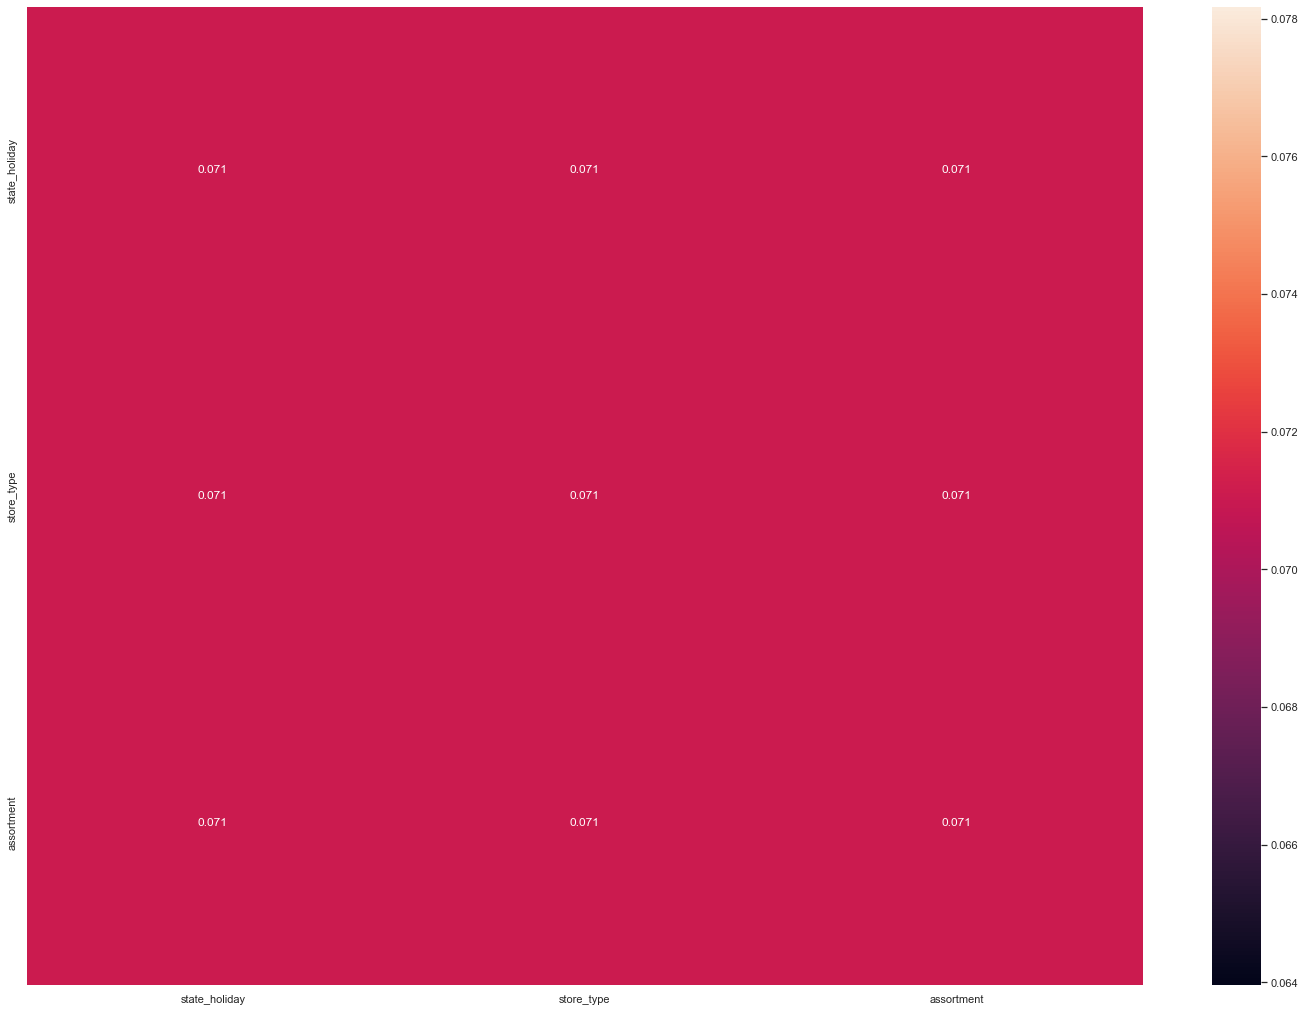

In [67]:

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

### Resumo das Hipoteses

In [68]:
from tabulate import tabulate

In [69]:
tab = [['Hipothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Low'],
       ['H8', 'False', 'Medium'],
       ['H9', 'False', 'High'],
       ['H10', 'False', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'High'],
       ['H13', 'True', 'Low'],
      ]
print( tabulate( tab, headers='firstrow') )

Hipothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Low
H8            False         Medium
H9            False         High
H10           False         High
H11           True          High
H12           True          High
H13           True          Low


# 5.0. Data Preparation

In [70]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling

In [71]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [72]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] =  rs.fit_transform( df5[['competition_distance']].values )

#competition time month
df5['competition_time_month'] =  rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] =  mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] =  mms.fit_transform( df5[['year']].values )


In [73]:
# day of week
# month
# day
# week of year

## 5.3. Transforming

### 5.3.1. Encoding

In [74]:
# state_holiday One hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# asssortment Ordinal encoding
assortment_dict = {'basic': 1,'extra': 2,'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variabe Transformation

In [75]:
df5['sales'] = np.log1p (df5['sales'] )

### 5.3.3. Response Variabe Transformation

In [76]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply ( lambda x: np.sin(x * ( 2. * np.pi / 7 ) ) )
df5['day_of_week_sin'] = df5['day_of_week'].apply ( lambda x: np.cos(x * ( 2. * np.pi / 7 ) ) )

 
# month
df5['month_sin'] = df5['month'].apply ( lambda x: np.sin(x * ( 2. * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply ( lambda x: np.cos(x * ( 2. * np.pi / 12 ) ) )

# day
df5['day_sin'] = df5['day'].apply ( lambda x: np.sin(x * ( 2. * np.pi / 30 ) ) )
df5['day_cos'] = df5['day'].apply ( lambda x: np.cos(x * ( 2. * np.pi / 30 ) ) )


# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply ( lambda x: np.sin(x * ( 2. * np.pi / 52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply ( lambda x: np.cos(x * ( 2. * np.pi / 52 ) ) )

In [77]:
df6.sample(10)

NameError: name 'df6' is not defined

# 6.0. Feature Selection

In [79]:
 df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [80]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since' , 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [81]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [93]:
# training set
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_train['sales']

print( " Training min  date: {}".format( X_train['date'].min() ) )
print( " Training max  date: {}".format( X_train['date'].max() ) )

print( "\nTraining min  date: {}".format( X_train['date'].min() ) )
print( " Training max  date: {}".format( X_train['date'].max() ) )

 Training min  date: 2013-01-01 00:00:00
 Training max  date: 2015-06-18 00:00:00

Training min  date: 2013-01-01 00:00:00
 Training max  date: 2015-06-18 00:00:00


## 6.2. Boruta as Feature Selector

In [ ]:
# training and test dataset for boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
Y_train_n = Y_train.values.ravel()

# define RandmomForestRegressor
rf = RandomForestRegressor ( n_jobs=1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit( X_train_n, Y_train_n )

### 6.2.1. Best Features from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))

In [ ]:
cols_not_selected_boruta 

In [ ]:
cols_selected_boruta

## 6.3. Manual Feature Selection

In [ ]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
  'day_of_week_cos',
  'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta.extend( feat_to_add )

In [ ]:
cols_selected_boruta

# 7.0. Machine Learning Modelling

In [ ]:
x_train = X_train['cols_selected_boruta']
x_test = X_test['cols_selected_boruta']

## 7.1. Average Model

In [ ]:
aux1 - x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how=left, on='store' )
yhat_baseline = aux1 ['predictions' ]

# performance
baseline_result = ml_error ( 'Average Model', y_test, yhat_baseline )
baseline_result

## 7.2. Linear Regression Model

In [ ]:
# model
lr = LinearRegressor().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test )
# performance
lr_result = m_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr) )
lr_result

## 7.3. Linear Regression Regularized Model - Lasso

In [ ]:
# model
lrr = Lasso(alpha=0.01 ).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test )
# performance
lrr_result = m_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr) )
lrr_result

# 8.0.

# 1.0.